# I. Analisis Data PKB

- business insight yang dapat digunakan untuk pengambilan keputusan (at least 2 tema bisnis terkait analisis)
- sajikan dalam sebuah presentasi
- pengerjaan analisis data disimpan dalam github

## Poin Penilaian

- ketelitian
- perumusan masalah
- langkah analisis data
- penyajian output yang inline dengan perumusan masalah
- dampak atas output yang diberikan



## Goals

```md
MASALAH 
|- ANALISIS DATA
   |- OUTPUT
      |- EFEK
         |- PENGETAHUAN YANG BISA DIPEROLEH
            |- PENGAMBILAN KEPUTUSAN
```

## Insight

1. Melihat pola waktu pembayaran pengguna kendaraan bermotor sehingga dapat dianalisis rutinitas waktu saat pengguna tersebut telat melakukan pembayaran -> kebijakan ??
2. Melihat daya bayar pengguna kendaraan bermotor
3. Mana pengguna kendaraan yang paling sering telat membayar
4. Kapan frekuensi kendaraan tertinggi yang terdaftar dan keluar? Dapat dilihat juga mobil mana yang paling umum, tipenya apa, dimana lokasi yang paling banyak? 

## Praproses Data

### 1. Pustaka and fungsi diimpor

Tahap awal praproses data adalah dengan memuat pustaka python yang dibutuhkan dan membuat *user-defined function* sebagai alat untuk inspeksi awal data.

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

def show_data(df, row=5):
    print(f'ukuran data: {df.shape}')
    display(df.head(row))

def get_missing_data_summary(df):
    temp = df.isnull().sum().reset_index()
    temp.columns = ['col_name', 'num_missing']
    temp['col_type'] = df.dtypes.values
    temp = temp.sort_values(by = 'num_missing', ascending = False)
    temp['num_missing_percent'] = round(temp['num_missing'] / len(df) * 100, 2)
    return(temp)


### 2. Data dimuat

In [115]:
df_payment = pd.read_csv("dataset/pembayaran.csv")
show_data(df_payment)

ukuran data: (3869, 4)


,Nopol,Tgl Bayar,Bayar,Denda
0,B5944XYZ,2018-04-19,1525111,381277
1,B5944XYZ,2018-08-31,1525111,0
2,B5944XYZ,2020-01-03,1525111,381277
3,B5944XYZ,2020-10-05,1525111,0
4,B5944XYZ,2021-06-19,1525111,0


In [116]:
# mengubah tipe kolom tanggal bayar
df_payment['Tgl Bayar'] = pd.to_datetime(df_payment['Tgl Bayar'])

In [117]:
df_payment.nunique()

Nopol         950
Tgl Bayar    2150
Bayar         999
Denda         752
dtype: int64

Data `pembayaran.csv` berisi 3869 data transaksi pembayaran pajak kendaraan bermotor dengan 4 atribut atau variabel sebagai berikut:
1. `Nopol`: Nomor plat kendaraan bermotor
2. `Tgl Bayar`: Tanggal pembayaran pajak kendaraan terkait
3. `Bayar`: Nominal pembayaran berdasarkan PKB Pokok
4. `Denda`: Nominal denda keterlambatan pembayaran PKB

Dari seluruh amatan tersebut terdapat sejumlah `950` **kendaraan bermotor unik** yang telah melakukan transaksi.

In [120]:
df_profil_op = pd.read_csv("dataset/profil_op.csv")
show_data(df_profil_op)

ukuran data: (1000, 9)


,Nopol,Domisili,Tgl Daftar,Tgl Keluar,Jenis Kendaraan,Merk Kendaraan,Tipe Kendaraan,Jenis Bahan Bakar,PKB Pokok
0,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111
1,B1576XYZ,Bandung,2017-01-13,2017-03-14,Motor,Kawasaki,Sport,Bensin,1425635
2,B5008XYZ,Bogor,2016-03-19,2020-07-14,Mobil,Toyota,SUV,n,1157953
3,B2905XYZ,Medan,2019-02-07,2024-04-30,Mobil,Daihatsu,SUV,n,882176
4,B3578XYZ,Bandung,2022-02-24,2023-04-04,Motor,Kawasaki,Sport,Bensin,1626497


In [121]:
# mengubah tipe kolom tanggal daftar dan keluar
df_profil_op['Tgl Daftar'] = pd.to_datetime(df_profil_op['Tgl Daftar'])
df_profil_op['Tgl Keluar'] = pd.to_datetime(df_profil_op['Tgl Keluar'])

In [122]:
df_profil_op.nunique()

Nopol                950
Domisili               5
Tgl Daftar           840
Tgl Keluar           890
Jenis Kendaraan        2
Merk Kendaraan         8
Tipe Kendaraan         2
Jenis Bahan Bakar      6
PKB Pokok            999
dtype: int64

Data `profil_op.csv` berisi 1000 amatan profil kendaraan bermotor dengan 9 atribut atau variabel sebagai berikut:
1. `Nopol`: Nomor plat kendaraan bermotor
2. `Domisili`: Tanggal pembayaran pajak kendaraan terkait
3. `Tgl Daftar`: Tanggal kendaraan pertama kali terdaftar dalam sistem administrasi kendaraan bermotor 
4. `Tgl Keluar`: Tanggal kendaraan dihapus dari sistem
5. `Jenis Kendaraan`: Jenis kendaraan Mobil atau Motor
6. `Merk Kendaraan`: Merk kendaraan bermotor
7. `Tipe Kendaraan`: Tipe kendaraan SUV atau Sport
8. `Jenis Bahan Bakar`: Jenis bahan bakar kendaraan
9. `PKB Pokok`: Nominal pajak kendaraan pokok

### 3. Data dibersihkan

Pada kedua data tersebut dapat diidentifikasi atribut unik yang dapat digunakan untuk penggabungan data. Namun sebelum dan sesudah hal tersebut dilakukan perlu adanya:
- pemeriksaan ketepatan tanggal kendaraan terdaftar dan keluar 
- pemeriksaan duplikasi data, terutama pada `Nopol` dan `PKB Pokok` yang akan dijadikan *key* untuk join data.
- pemeriksaan kategori pada atribut `Jenis Bahan Bakar`
- pemeriksaan ketepatan tanggal kendaraan terdaftar dan tanggal pembayaran pajak

In [134]:
df_profil_filtered = df_profil_op[df_profil_op['Tgl Daftar'] <= df_profil_op['Tgl Keluar']]
show_data(df_profil_filtered)

ukuran data: (953, 9)


,Nopol,Domisili,Tgl Daftar,Tgl Keluar,Jenis Kendaraan,Merk Kendaraan,Tipe Kendaraan,Jenis Bahan Bakar,PKB Pokok
0,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111
1,B1576XYZ,Bandung,2017-01-13,2017-03-14,Motor,Kawasaki,Sport,Bensin,1425635
2,B5008XYZ,Bogor,2016-03-19,2020-07-14,Mobil,Toyota,SUV,n,1157953
3,B2905XYZ,Medan,2019-02-07,2024-04-30,Mobil,Daihatsu,SUV,n,882176
4,B3578XYZ,Bandung,2022-02-24,2023-04-04,Motor,Kawasaki,Sport,Bensin,1626497


In [135]:
nopol = df_profil_filtered['Nopol']
duplicate_nopol = pd.Series(nopol)[pd.Series(nopol).duplicated()].values
duplicate_nopol

array(['B7049XYZ', 'B5008XYZ', 'B6595XYZ', 'B6508XYZ', 'B4658XYZ',
       'B5948XYZ', 'B7329XYZ', 'B9269XYZ', 'B7012XYZ', 'B6689XYZ',
       'B4275XYZ', 'B5366XYZ', 'B1611XYZ', 'B3558XYZ', 'B2042XYZ',
       'B9337XYZ', 'B3975XYZ', 'B1502XYZ', 'B8227XYZ', 'B5209XYZ',
       'B2907XYZ', 'B1874XYZ', 'B3531XYZ', 'B9699XYZ', 'B7266XYZ',
       'B2042XYZ', 'B5882XYZ', 'B1631XYZ', 'B1874XYZ', 'B5667XYZ',
       'B1733XYZ', 'B9824XYZ', 'B9793XYZ', 'B7212XYZ', 'B3558XYZ',
       'B3795XYZ', 'B4552XYZ', 'B7413XYZ', 'B2746XYZ', 'B3462XYZ',
       'B7086XYZ', 'B9547XYZ', 'B8417XYZ', 'B2393XYZ'], dtype=object)

In [136]:
print(f'Terdapat {len(duplicate_nopol)} duplikasi pada nopol')

Terdapat 44 duplikasi pada nopol


In [137]:
df_profil_filtered.groupby(['Jenis Bahan Bakar', 'Jenis Kendaraan']).size().unstack(fill_value=0)

Jenis Kendaraan,Mobil,Motor
Jenis Bahan Bakar,,
B,87,0
Bensin,0,493
e,64,0
i,89,0
n,162,0
s,58,0


Terdapat beberapa kategori `Jenis Bahan Bakar` yang tidak teridentifikasi pada dataset dan semuanya masuk ke dalam kategori `Jenis Kendaraan` = `Mobil`, hanya kategori `Motor` yang dengan jelas menggunakan bahan bakar `Bensin`. Pada aspek ini tidak menjadi isu karena lebih mudah membedakannya dengan melihat jenis kendaraannya saja. 

In [138]:
missing_df_payment = get_missing_data_summary(df_payment)
missing_df_payment

,col_name,num_missing,col_type,num_missing_percent
0,Nopol,0,object,0.0
1,Tgl Bayar,0,datetime64[ns],0.0
2,Bayar,0,int64,0.0
3,Denda,0,int64,0.0


In [139]:
missing_df_profil = get_missing_data_summary(df_profil_filtered)
missing_df_profil

,col_name,num_missing,col_type,num_missing_percent
0,Nopol,0,object,0.0
1,Domisili,0,object,0.0
2,Tgl Daftar,0,datetime64[ns],0.0
3,Tgl Keluar,0,datetime64[ns],0.0
4,Jenis Kendaraan,0,object,0.0
5,Merk Kendaraan,0,object,0.0
6,Tipe Kendaraan,0,object,0.0
7,Jenis Bahan Bakar,0,object,0.0
8,PKB Pokok,0,int64,0.0


Tabel ringkasan di atas menunjukkan bahwa tidak ada langkah lebih lanjut yang perlu dilakukan, karena kedua tabel tidak memiliki nilai yang hilang pada setiap atributnya. 

### 4. Data digabungkan

In [174]:
df_merged = df_profil_filtered.merge(df_payment, left_on = ["Nopol", "PKB Pokok"], right_on = ["Nopol", "Bayar"], how = "left")
show_data(df_merged)

ukuran data: (3814, 12)


,Nopol,Domisili,Tgl Daftar,Tgl Keluar,Jenis Kendaraan,Merk Kendaraan,Tipe Kendaraan,Jenis Bahan Bakar,PKB Pokok,Tgl Bayar,Bayar,Denda
0,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2018-04-19,1525111,381277
1,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2018-08-31,1525111,0
2,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2020-01-03,1525111,381277
3,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2020-10-05,1525111,0
4,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2021-06-19,1525111,0


In [241]:
df_final = df_merged[df_merged['Tgl Daftar'] <= df_merged['Tgl Bayar']]
show_data(df_final)

ukuran data: (3350, 12)


,Nopol,Domisili,Tgl Daftar,Tgl Keluar,Jenis Kendaraan,Merk Kendaraan,Tipe Kendaraan,Jenis Bahan Bakar,PKB Pokok,Tgl Bayar,Bayar,Denda
0,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2018-04-19,1525111,381277
1,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2018-08-31,1525111,0
2,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2020-01-03,1525111,381277
3,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2020-10-05,1525111,0
4,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2021-06-19,1525111,0


### 5. Rekayasa fitur

Tahapan berikut ini dilakukan rekayasa fitur terhadap ketepatan pembayaran PKB dengan atribut `Status Denda` = `[Ontime, Denda]`

In [242]:
df_final['Status Denda'] = np.where(df_final['Denda'] == 0, 1, 0)
df_final['Durasi Keterlambatan'] = np.where(df_final['Denda'] == 0, 
                                            df_final['Tgl Daftar'] - df_final['Tgl Daftar'], 
                                            df_final['Tgl Bayar'] - df_final['Tgl Daftar'])
df_final['Level PKB'] = np.where(df_final['PKB Pokok'] < 999999, "Rendah", 
                                 np.where(df_final['PKB Pokok'] < 1499999, "Sedang", "Tinggi"))
show_data(df_final)

ukuran data: (3350, 15)


,Nopol,Domisili,Tgl Daftar,Tgl Keluar,Jenis Kendaraan,Merk Kendaraan,Tipe Kendaraan,Jenis Bahan Bakar,PKB Pokok,Tgl Bayar,Bayar,Denda,Status Denda,Durasi Keterlambatan,Level PKB
0,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2018-04-19,1525111,381277,0,328 days,Tinggi
1,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2018-08-31,1525111,0,1,0 days,Tinggi
2,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2020-01-03,1525111,381277,0,952 days,Tinggi
3,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2020-10-05,1525111,0,1,0 days,Tinggi
4,B5944XYZ,Jakarta,2017-05-26,2022-06-30,Motor,Suzuki,Sport,Bensin,1525111,2021-06-19,1525111,0,1,0 days,Tinggi


## Exploratory Data Analysis

### Pivot Table

In [250]:
pd.pivot_table(df_final, values='Status Denda', index=['Domisili', 'Level PKB'], columns='Jenis Kendaraan', aggfunc='sum', fill_value=0)

Jenis Kendaraan     Mobil  Motor
Domisili Level PKB              
Bandung  Rendah        66     59
         Sedang        49     71
         Tinggi        70     59
Bogor    Rendah        85     58
         Sedang        62     73
         Tinggi        43     69
Jakarta  Rendah        66     65
         Sedang        51     39
         Tinggi        33     59
Medan    Rendah        70     63
         Sedang        64     78
         Tinggi        67     70
Surabaya Rendah        52     58
         Sedang        38     76
         Tinggi       108     84

### Analisis Univariate

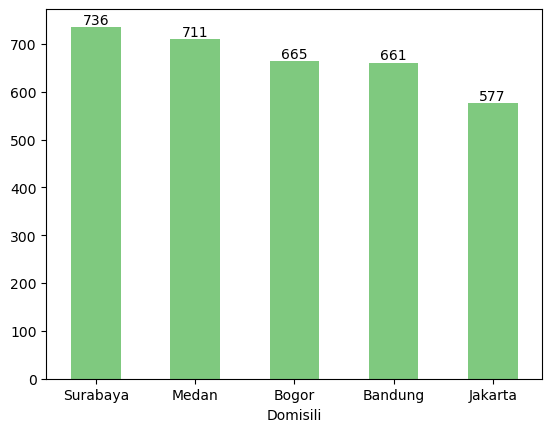

In [193]:
ax1 = df_final['Domisili'].value_counts().plot(kind='bar', rot=360, colormap='Accent')
for container in ax1.containers:
    ax1.bar_label(container)

Text(0, 0.5, 'Total')

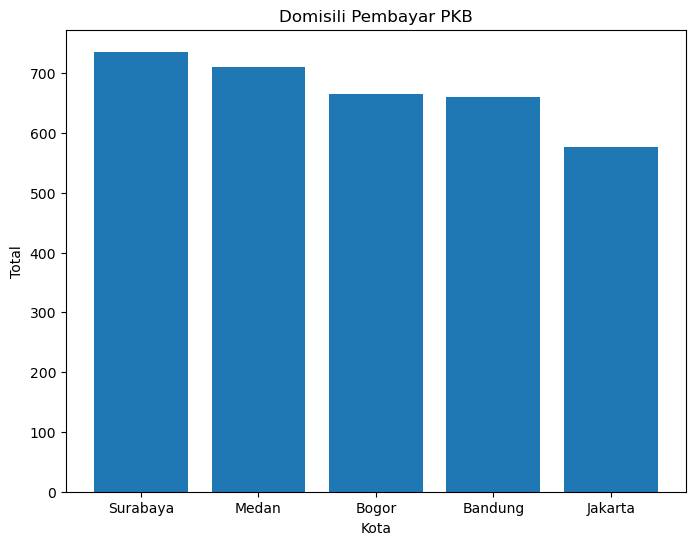

In [156]:
domisili_counts = df_final['Domisili'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(domisili_counts.index, domisili_counts)
plt.title('Domisili Pembayar PKB')
plt.xlabel('Kota')
plt.ylabel('Total')

Text(0, 0.5, 'Total')

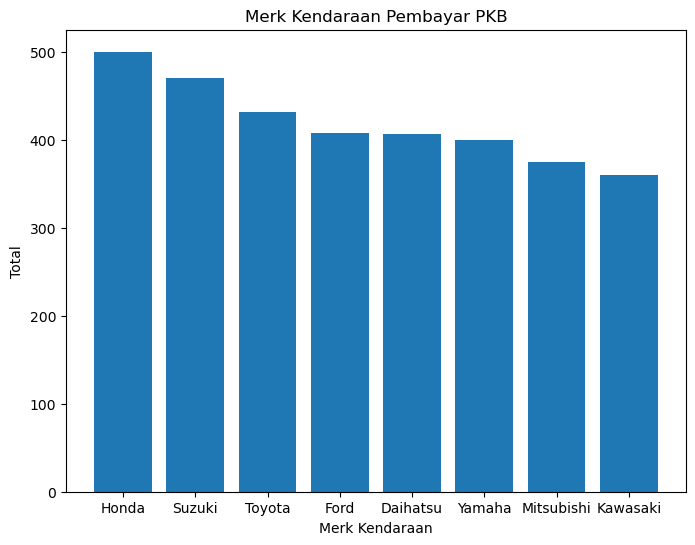

In [158]:
merk_counts = df_final['Merk Kendaraan'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(merk_counts.index, merk_counts)
plt.title('Merk Kendaraan Pembayar PKB')
plt.xlabel('Merk Kendaraan')
plt.ylabel('Total')

Text(0, 0.5, 'Total')

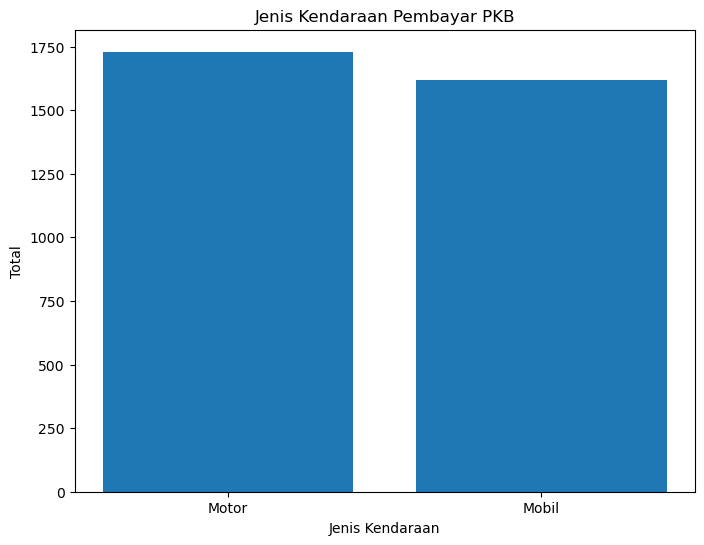

In [159]:
jenis_counts = df_final['Jenis Kendaraan'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(jenis_counts.index, jenis_counts)
plt.title('Jenis Kendaraan Pembayar PKB')
plt.xlabel('Jenis Kendaraan')
plt.ylabel('Total')

### Analisis Bivariate

In [161]:
pd.crosstab(df_final['Status Denda'], df_final['Domisili'], margins = True)

Domisili,Bandung,Bogor,Jakarta,Medan,Surabaya,All
Status Denda,,,,,,
Denda,287,275,264,299,320,1445
Ontime,374,390,313,412,416,1905
All,661,665,577,711,736,3350


In [162]:
pd.crosstab(df_final['Status Denda'], df_final['Merk Kendaraan'], margins = True)

Merk Kendaraan,Daihatsu,Ford,Honda,Kawasaki,Mitsubishi,Suzuki,Toyota,Yamaha,All
Status Denda,,,,,,,,,
Denda,189,169,229,150,164,198,174,172,1445
Ontime,217,239,271,210,211,272,257,228,1905
All,406,408,500,360,375,470,431,400,3350


In [163]:
pd.crosstab(df_final['Status Denda'], df_final['Jenis Kendaraan'], margins = True)

Jenis Kendaraan,Mobil,Motor,All
Status Denda,,,
Denda,696,749,1445
Ontime,924,981,1905
All,1620,1730,3350


In [231]:
pd.crosstab(df_final['Domisili'], df_final['Level PKB'], df_final['Status Denda'], aggfunc='count')

Level PKB,Rendah,Sedang,Tinggi
Domisili,,,
Bandung,224,214,223
Bogor,232,236,197
Jakarta,223,164,190
Medan,235,228,248
Surabaya,194,228,314


### Analisis Multivariate

In [232]:
n = df_final[['Nopol', 'Domisili','Level PKB','Status Denda']].groupby(by=['Domisili','Level PKB','Status Denda']).count().unstack(level=1)
n

Nopol              
Level PKB             Rendah Sedang Tinggi
Domisili Status Denda                     
Bandung  Denda            99     94     94
         Ontime          125    120    129
Bogor    Denda            89    101     85
         Ontime          143    135    112
Jakarta  Denda            92     74     98
         Ontime          131     90     92
Medan    Denda           102     86    111
         Ontime          133    142    137
Surabaya Denda            84    114    122
         Ontime          110    114    192

<Axes: xlabel='None-Level PKB', ylabel='Domisili-Status Denda'>

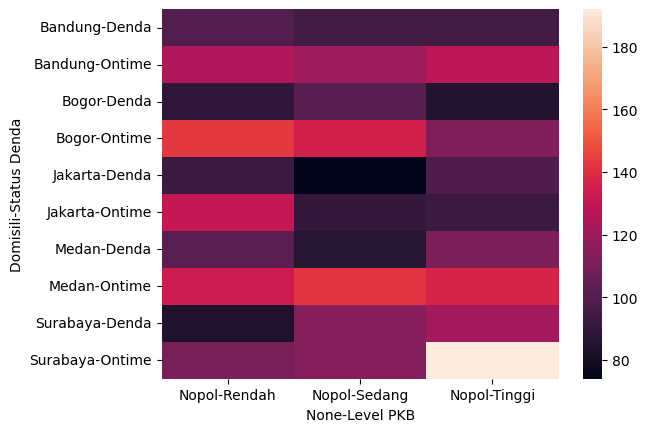

In [233]:
sns.heatmap(n)

In [234]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [ ]:
sns.catplot(
    data=df_final, y="Status Denda", hue="class", kind="count",
    palette="pastel", edgecolor=".6",
)

# II. Penggunaan AI / Machine Learning

- ide yang digunakan
- nilai tambah yang bisa diperoleh bagi Potensi Pajak
- berikan analisis dan insight

In [ ]:
df_ml = df_final

features = ['Domisili', 'Jenis Kendaraan']

d1 = {'Bandung': 0, 'Bogor': 1, 'Jakarta': 2, 'Medan': 3, 'Surabaya': 4}
d2 = {'Daihatsu': 0, 'Ford': 1, 'Honda': 2, 'Kawasaki': 3, 'Mitsubishi': 4, 'Suzuki': 5, 'Toyota': 6, 'Yamaha': 7}
d3 = {'Mobil': 0, 'Motor': 1}
d4 = {'Denda': 0, 'Ontime': 1}

df_ml['Jenis Kendaraan'] = df_ml['Jenis Kendaraan'].map(d3)
df_ml['Merk Kendaraan'] = df_ml['Merk Kendaraan'].map(d2)
df_ml['Domisili'] = df_ml['Domisili'].map(d1)
df_ml['Status Denda'] = df_ml['Status Denda'].map(d4)

X = df_ml[features]
y = df_ml['Status Denda']

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)

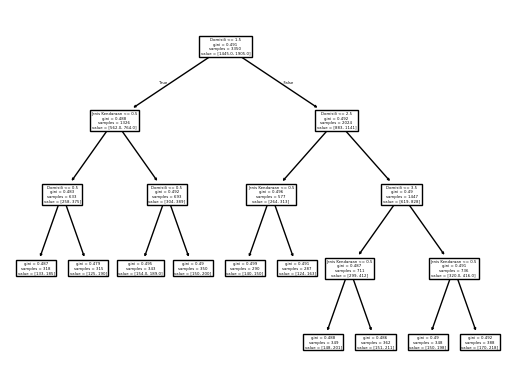

In [202]:
u = tree.plot_tree(dtree, feature_names = features)